# **ASHRAE - Great Energy Predictor III**

#### **Mounting the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Importing the Libraries**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss
from keras.callbacks import CSVLogger

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df


#### **Preparing the training data**


In [0]:
building_df = pd.read_csv("/content/drive/My Drive/data/building_metadata.csv")
weather_train = pd.read_csv("/content/drive/My Drive/data/weather_train.csv")
train = pd.read_csv("/content/drive/My Drive/data/train.csv")

train = train.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"])
del weather_train

train.loc[(train['meter']==0) & (train['site_id']==0) & (train['timestamp']<'2016-05-21 00:00:00'), 'drop'] = True
train = train[train['drop']!=True]

train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["weekday"] = train["timestamp"].dt.weekday

train = average_imputation(train, 'wind_speed')

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

del train["timestamp"]

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday",  "meter"]

drop_cols = ["sea_level_pressure", "wind_speed", "wind_direction"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", "precip_depth_1_hr", "floor_count", 'beaufort_scale']

feat_cols = categoricals + numericals

In [0]:
target = np.log1p(train["meter_reading"])

del train["meter_reading"] 

train = train.drop(drop_cols, axis = 1)

#### **Reducing Memory Usage**


In [0]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [8]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 3054.1900634765625  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
******************************
Column:  year_built
dtype before:  float64
min for this col:  1900.0
m

#### **Defining the model**


In [0]:
def model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001):

    #Inputs
    site_id = Input(shape=[1], name="site_id")
    building_id = Input(shape=[1], name="building_id")
    meter = Input(shape=[1], name="meter")
    primary_use = Input(shape=[1], name="primary_use")
    square_feet = Input(shape=[1], name="square_feet")
    year_built = Input(shape=[1], name="year_built")
    air_temperature = Input(shape=[1], name="air_temperature")
    cloud_coverage = Input(shape=[1], name="cloud_coverage")
    dew_temperature = Input(shape=[1], name="dew_temperature")
    hour = Input(shape=[1], name="hour")
    precip = Input(shape=[1], name="precip_depth_1_hr")
    weekday = Input(shape=[1], name="weekday")
    beaufort_scale = Input(shape=[1], name="beaufort_scale")
   
    #Embeddings layers
    emb_site_id = Embedding(16, 2)(site_id)
    emb_building_id = Embedding(1449, 6)(building_id)
    emb_meter = Embedding(4, 2)(meter)
    emb_primary_use = Embedding(16, 2)(primary_use)
    emb_hour = Embedding(24, 3)(hour)
    emb_weekday = Embedding(7, 2)(weekday)

    concat_emb = concatenate([
           Flatten() (emb_site_id)
         , Flatten() (emb_building_id)
         , Flatten() (emb_meter)
         , Flatten() (emb_primary_use)
         , Flatten() (emb_hour)
         , Flatten() (emb_weekday)
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([
          categ
        , square_feet
        , year_built
        , air_temperature
        , cloud_coverage
        , dew_temperature
        , precip
        , beaufort_scale
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    #output
    output = Dense(1) (main_l)

    model = Model([ site_id,
                    building_id, 
                    meter, 
                    primary_use, 
                    square_feet, 
                    year_built, 
                    air_temperature,
                    cloud_coverage,
                    dew_temperature, 
                    hour,
                    weekday, 
                    precip,
                    beaufort_scale], output)

    model.compile(optimizer = Adam(lr=lr),
                  loss= mse_loss,
                  metrics=[root_mean_squared_error])
    return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [0]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold, patience=3):
    csv_logger = CSVLogger('training_{}.log'.format(fold), separator=',', append=False)
    early_stopping = EarlyStopping(patience=patience, verbose=1)
    model_checkpoint = ModelCheckpoint("model_" + str(fold) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_root_mean_squared_error', mode='min')

    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=1,
                            callbacks=[early_stopping, model_checkpoint, csv_logger])

    keras_model = load_model("model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    return keras_model

#### **Training the model**


In [11]:
from sklearn.model_selection import KFold, StratifiedKFold

oof = np.zeros(len(train))
batch_size = 1024
epochs = 10
models = []

folds = 2
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

for fold_n, (train_index, valid_index) in enumerate(kf.split(train, train['building_id'])):
    print('Fold:', fold_n)
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_t = get_keras_data(X_train, numericals, categoricals)
    X_v = get_keras_data(X_valid, numericals, categoricals)
    
    keras_model = model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
                        dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001)
    mod = train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold_n, patience=3)
    models.append(mod)
    print('*'* 50)
    

Fold: 0




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 9888192 samples, validate on 9888853 samples
Epoch 1/10





9888192/9888192 [==============================] - 123s 12us/step - loss: 1.9872 - root_mean_squared_error: 1.3782 - val_loss: 1.4549 - val_root_mean_squared_error: 1.1900

Epoch 00001: val_root_mean_squared_error improved from inf to 1.19001, saving model to model_0.hdf5
Epoch 2/10
9888192/9888192 [==============================] - 118s 12us/step - loss: 1.5592 - root_mean_squared_error: 1.2474 - val_loss: 1.4563 - val_root_mean_squared_error: 1.1904

Epoch 00002: val_root_mean_squared_error did not improve from 1.19001
Epoch 3/10
9888192/9888192 [==============================] - 118s 12us/step - loss: 1.5195 - root_mean_squared_error: 1.2314 - val_loss: 1.4267 - val_root_mean_squared_error: 1.1793

Epoch 00003: val_root_mean_squared_error improved from 1.19001 to 1.17934, saving model 

#### **Removing unecessary variables**


In [0]:
import gc
del train, target, X_train, X_valid, y_train, y_valid, X_t, X_v, kf
gc.collect()

#### **Preparing the test data**


In [0]:
test = pd.read_csv("/content/drive/My Drive/data/test.csv")
test = test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
del building_df
gc.collect()
test["primary_use"] = le.transform(test["primary_use"])

weather_test = pd.read_csv("/content/drive/My Drive/data/weather_test.csv")

test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
del weather_test

In [14]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = test["timestamp"].dt.hour
test["weekday"] = test["timestamp"].dt.weekday

test = average_imputation(test, 'wind_speed')

for item in beaufort:
    test.loc[(test['wind_speed']>=item[1]) & (test['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

    
test = test[feat_cols]
test, NAlist = reduce_mem_usage(test)

Memory usage of properties dataframe is : 6051.91162109375  MB
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  hour
dtype before:  int64
min for this col:  0
max for this col:  23
dtype after:  uint8
******************************
******************************
Column:  weekday
dtype before:  int64
min for this col:  0
max for this col:  6
dtype after:  uint8
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype 

#### **Making predictions**


In [15]:
from tqdm import tqdm
i=0
res = np.zeros((test.shape[0]),dtype=np.float32)
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/step_size)))):
    for_prediction = get_keras_data(test.iloc[i:i+step_size], numericals, categoricals)
    res[i:min(i+step_size,test.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    i+=step_size

100%|██████████| 834/834 [03:53<00:00,  3.63it/s]


In [16]:
submission = pd.read_csv('/content/drive/My Drive/data/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading'] < 0, 'meter_reading'] = 0
submission.to_csv('/content/drive/My Drive/data/submission.csv', index=False)
submission

,row_id,meter_reading
0,0,176.266251
1,1,104.670525
2,2,16.037224
3,3,243.080490
4,4,1211.738770
...,...,...
41697595,41697595,10.247118
41697596,41697596,8.820972
41697597,41697597,6.553712
41697598,41697598,148.624329


,row_id,meter_reading
0,0,176.266251
1,1,104.670525
2,2,16.037224
3,3,243.080490
4,4,1211.738770
...,...,...
41697595,41697595,10.247118
41697596,41697596,8.820972
41697597,41697597,6.553712
41697598,41697598,148.624329


In [0]:
df = pd.read_csv("training_1.log")
import matplotlib.pyplot as plt

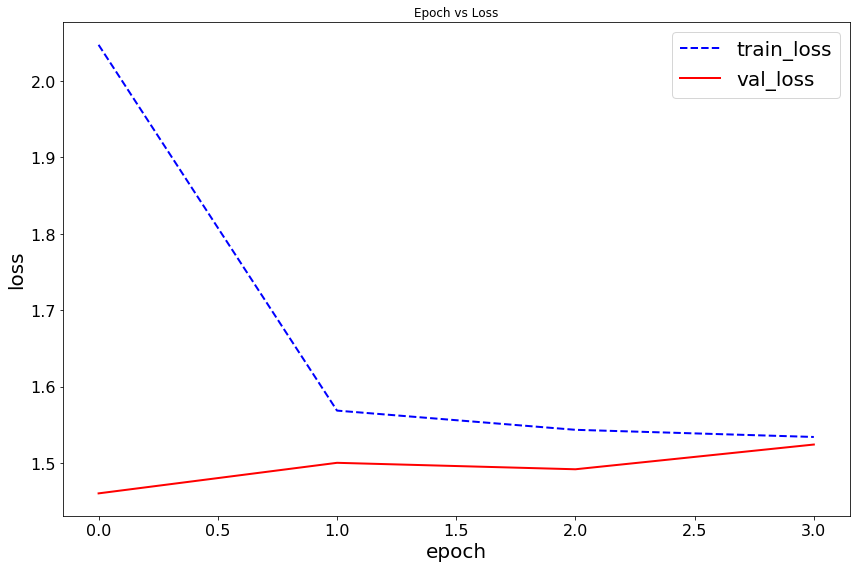

In [22]:
%matplotlib inline

fig = plt.figure(figsize=(12, 8))

line0, = plt.plot(df['epoch'], df['loss'], '--b', LineWidth=2)
line1, = plt.plot(df['epoch'], df['val_loss'], '-r', LineWidth=2)
plt.title('Epoch vs Loss')
plt.xlabel('epoch', FontSize=20)
plt.ylabel('loss', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['train_loss', 'val_loss'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('Epoch_vs_Loss.png', format='pdf', dpi=1200)

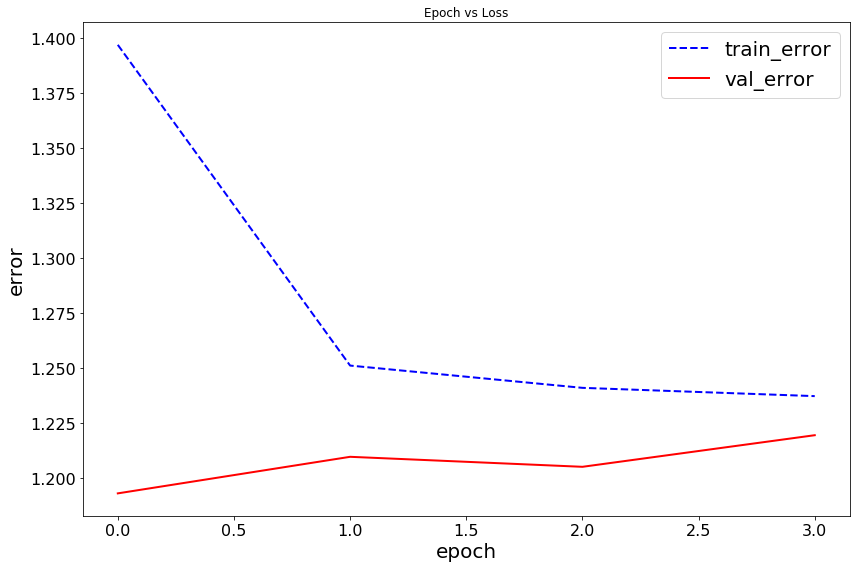

In [23]:
%matplotlib inline

fig = plt.figure(figsize=(12, 8))

line0, = plt.plot(df['epoch'], df['root_mean_squared_error'], '--b', LineWidth=2)
line1, = plt.plot(df['epoch'], df['val_root_mean_squared_error'], '-r', LineWidth=2)
plt.title('Epoch vs Loss')
plt.xlabel('epoch', FontSize=20)
plt.ylabel('error', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['train_error', 'val_error'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('Epoch_vs_Error.png', format='pdf', dpi=1200)